In [153]:
# used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import os
from dotenv import load_dotenv


In [266]:
# defined functions for pipeline
def acquire():
    raw_data = pd.read_csv('data\database.csv')
    return raw_data

def clean_nulls(raw_data):
    null_cols = raw_data.isnull().sum()
    drop_cols = list(null_cols[null_cols > 1000].index)
    data = raw_data.drop(drop_cols, axis=1)
    data = data.drop(['Type','ID','Source','Magnitude Type','Location Source', 'Magnitude Source','Status'], axis=1)
    return data

def binning_data(data):
    magnitude_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    bins = pd.cut(data['Magnitude'],5, labels=magnitude_labels)
    data['MagBin'] = bins
    binned_data = data
    return binned_data

def filtering_data(binned_data):
    bins_delete = ['Very Low', 'Low']
    filtered_data = binned_data[~binned_data.MagBin.isin(bins_delete)]
    filtered_data = filtered_data.reset_index().drop(['index'], axis=1)
    return filtered_data


def api_opencage(filtered_data):
#https://opencagedata.com/demo
    location = []
    load_dotenv('.env')
    key = os.environ.get("oc_key")
    for i in range(len(filtered_data.head())): # head para limitar el numero de llamadas hasta que el codigo este probado
        try:
            lat = filtered_data['Latitude'][i]
            long = filtered_data['Longitude'][i]
            url = ('https://api.opencagedata.com/geocode/v1/json?q={}%2C{}&key={}&language=en&pretty=1&no_annotations=1'.format(lat,long,key))
            response = requests.get(url)
            results = response.json()
            continent = results['results'][0]['components']['continent']
            country = results['results'][0]['components']['country']
            state = results['results'][0]['components']['state']
        except:
            continent = 'No continent'
            country = 'No country'
            state = 'No state'
        location.append([continent, country, state])
    locdf = pd.DataFrame(location, columns = ['Continent', 'Country', 'State'])
    data_loc = pd.concat([filtered_data, locdf], axis=1, sort=False)
    return data_loc




In [267]:
if __name__ == '__main__':
    raw_data = acquire()
    data = clean_nulls(raw_data)
    binned_data = binning_data(data)
    filtered_data = filtering_data(binned_data)
    data_loc = api_opencage(filtered_data)
    display(data_loc.head())

,Date,Time,Latitude,Longitude,Depth,Magnitude,MagBin,Continent,Country,State
0,01/24/1965,00:11:17,-2.6080,125.9520,20.00,8.2,High,Asia,Indonesia,North Maluku
1,02/04/1965,05:01:22,51.2510,178.7150,30.30,8.7,Very High,No continent,No country,No state
2,02/04/1965,08:40:44,51.4430,179.6050,30.00,7.3,Moderate,North America,USA,Alaska
3,02/23/1965,22:11:47,-25.6330,-70.6790,35.00,7.0,Moderate,South America,Chile,Antofagasta Region
4,03/14/1965,15:53:07,36.4050,70.7240,207.80,7.4,Moderate,Asia,Afghanistan,Badakhshan
5,03/28/1965,16:33:16,-32.5220,-71.2330,70.00,7.4,Moderate,South America,Chile,Valparaiso Region
6,03/30/1965,02:27:06,50.2820,177.9590,20.00,7.6,Moderate,No continent,No country,No state
7,05/20/1965,00:40:27,-14.9210,167.3400,120.00,7.7,High,Oceania,Vanuatu,Sanma
8,06/11/1965,03:33:47,44.6080,149.0220,40.70,7.0,Moderate,No continent,No country,No state
9,06/11/1965,03:34:04,44.5780,148.6990,58.00,7.2,Moderate,No continent,No country,No state


,Date,Time,Latitude,Longitude,Depth,Magnitude,MagBin,Continent,Country,State
0,01/24/1965,00:11:17,-2.608,125.952,20.0,8.2,High,Asia,Indonesia,North Maluku
1,02/04/1965,05:01:22,51.251,178.715,30.3,8.7,Very High,No continent,No country,No state
2,02/04/1965,08:40:44,51.443,179.605,30.0,7.3,Moderate,North America,USA,Alaska
3,02/23/1965,22:11:47,-25.633,-70.679,35.0,7.0,Moderate,South America,Chile,Antofagasta Region
4,03/14/1965,15:53:07,36.405,70.724,207.8,7.4,Moderate,Asia,Afghanistan,Badakhshan


,Date,Time,Latitude,Longitude,Depth,Magnitude,MagBin
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0,Very Low
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8,Very Low
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2,Very Low
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8,Very Low
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8,Very Low


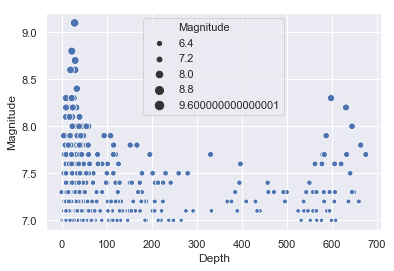

In [281]:
display(data_loc.head())
display(data.head())
sns.set_style("darkgrid")
sns.scatterplot('Depth', 'Magnitude', style=None, size='Magnitude', data=data_loc, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, x_bins=None, y_bins=None, units=None, estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, legend='brief', ax=None)   
    
    